<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#load-data" data-toc-modified-id="load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load data</a></span><ul class="toc-item"><li><span><a href="#read-in-the-files" data-toc-modified-id="read-in-the-files-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>read in the files</a></span><ul class="toc-item"><li><span><a href="#data-from-linear-and-relu-activations" data-toc-modified-id="data-from-linear-and-relu-activations-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>data from linear and relu activations</a></span></li></ul></li><li><span><a href="#create-pandas-table" data-toc-modified-id="create-pandas-table-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>create pandas table</a></span></li></ul></li><li><span><a href="#filter-out-bad-training-losses" data-toc-modified-id="filter-out-bad-training-losses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>filter out bad training losses</a></span></li><li><span><a href="#determine-the-lambda-parameter-that-gets-the-best-test-MSE-for-each-(r,n,L)" data-toc-modified-id="determine-the-lambda-parameter-that-gets-the-best-test-MSE-for-each-(r,n,L)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>determine the lambda parameter that gets the best test MSE for each (r,n,L)</a></span></li><li><span><a href="#Generalization-MSE" data-toc-modified-id="Generalization-MSE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Generalization MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Out-of-Distribution-MSE" data-toc-modified-id="Out-of-Distribution-MSE-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Out of Distribution MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Active-Subspace" data-toc-modified-id="Active-Subspace-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Active Subspace</a></span><ul class="toc-item"><li><span><a href="#evaluate-gradients-and-compute-singular-values-and-active-subspaces" data-toc-modified-id="evaluate-gradients-and-compute-singular-values-and-active-subspaces-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>evaluate gradients and compute singular values and active subspaces</a></span></li><li><span><a href="#plot-of-singular-values" data-toc-modified-id="plot-of-singular-values-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>plot of singular values</a></span></li></ul></li><li><span><a href="#determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)" data-toc-modified-id="determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>determine the L parameter that gets the best test MSE for each (r,n)</a></span></li><li><span><a href="#Plots-of-L-vs-Test-error-and-n-vs-Generalization-metrics-with/without-linear-layers" data-toc-modified-id="Plots-of-L-vs-Test-error-and-n-vs-Generalization-metrics-with/without-linear-layers-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plots of L vs Test error and n vs Generalization metrics with/without linear layers</a></span></li><li><span><a href="#Final-Table" data-toc-modified-id="Final-Table-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Final Table</a></span></li><li><span><a href="#Training-Time-Plots" data-toc-modified-id="Training-Time-Plots-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Training Time Plots</a></span><ul class="toc-item"><li><span><a href="#Train-MSE-v-Epoch" data-toc-modified-id="Train-MSE-v-Epoch-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Train MSE v Epoch</a></span></li><li><span><a href="#Weight-Decay-v-Epoch" data-toc-modified-id="Weight-Decay-v-Epoch-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Weight Decay v Epoch</a></span></li><li><span><a href="#learning-rates" data-toc-modified-id="learning-rates-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>learning rates</a></span></li></ul></li></ul></div>

# imports

In [25]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import ortho_group
from scipy.stats import linregress
from scipy import linalg as la
from torch import nn
import torch
import os

# load data

## read in the files

In [26]:
rnvals = [(1,64),(1,128),(1,256),(1,512),(1,1024),(1,2048),
          (2,64),(2,128),(2,256),(2,512),(2,1024),(2,2048)]
Ls = [2,3,4,5,6,7,8,9]
wds = [1e-3,1e-4,1e-5]
epochs = 60100
job_name = "GPUlabelnoise"#"GPUmanylayers"

### data from linear and relu activations

In [27]:
testMSEs = {}
trainMSEs = {}
weightdecays = {}
learningrates = {}
files_found_list = []
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            paramname = job_name+f"/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
            if os.path.exists(paramname+"testMSE.npy"):
                testMSEs[r,n,L,wd] = np.load(paramname+"testMSE.npy",allow_pickle=True).item()
                trainMSEs[r,n,L,wd] = np.load(paramname+"trainMSEs.npy",allow_pickle=True)
                weightdecays[r,n,L,wd] = np.load(paramname+"weightdecays.npy",allow_pickle=True)
                learningrates[r,n,L,wd] = np.load(paramname+"learningrates.npy",allow_pickle=True)
                files_found_list.append((r,n,L,wd))
            else:
                print(f"{paramname+'testMSE.npy'} not found")

GPUlabelnoise/N128_L2_r1_wd0.001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L2_r1_wd0.0001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L2_r1_wd1e-05_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L3_r1_wd0.001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L3_r1_wd0.0001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L3_r1_wd1e-05_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L4_r1_wd0.001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L4_r1_wd0.0001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L4_r1_wd1e-05_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L5_r1_wd0.001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L5_r1_wd0.0001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L5_r1_wd1e-05_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L6_r1_wd0.001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L6_r1_wd0.0001_epochs60100testMSE.npy not found
GPUlabelnoise/N128_L6_r1_wd1e-05_epochs60100testMSE.npy not found
GPUla

In [28]:
files_found_list

[(1, 64, 2, 0.001),
 (1, 64, 2, 0.0001),
 (1, 64, 2, 1e-05),
 (1, 64, 3, 0.001),
 (1, 64, 3, 0.0001),
 (1, 64, 3, 1e-05),
 (1, 64, 4, 0.001),
 (1, 64, 4, 0.0001),
 (1, 64, 4, 1e-05),
 (1, 64, 5, 0.001),
 (1, 64, 5, 0.0001),
 (1, 64, 5, 1e-05),
 (1, 64, 6, 0.001),
 (1, 64, 6, 0.0001),
 (1, 64, 6, 1e-05),
 (1, 64, 7, 0.001),
 (1, 64, 7, 0.0001),
 (1, 64, 7, 1e-05),
 (1, 64, 8, 0.001),
 (1, 64, 8, 0.0001),
 (1, 64, 8, 1e-05),
 (1, 64, 9, 0.001),
 (1, 64, 9, 0.0001),
 (1, 64, 9, 1e-05),
 (2, 64, 2, 0.001),
 (2, 64, 2, 0.0001),
 (2, 64, 2, 1e-05),
 (2, 64, 3, 0.001),
 (2, 64, 3, 0.0001),
 (2, 64, 3, 1e-05),
 (2, 64, 4, 0.001),
 (2, 64, 4, 0.0001),
 (2, 64, 4, 1e-05),
 (2, 64, 5, 0.001),
 (2, 64, 5, 0.0001),
 (2, 64, 5, 1e-05),
 (2, 64, 6, 0.001),
 (2, 64, 6, 0.0001),
 (2, 64, 6, 1e-05),
 (2, 64, 7, 0.001),
 (2, 64, 7, 0.0001),
 (2, 64, 7, 1e-05),
 (2, 64, 8, 0.001),
 (2, 64, 8, 0.0001),
 (2, 64, 8, 1e-05),
 (2, 64, 9, 0.001),
 (2, 64, 9, 0.0001),
 (2, 64, 9, 1e-05)]

In [29]:
def Llayers(L,d=20,width=1000):
    #construct L-1 linear layers; bias term only on last linear layer
    if L < 2:
        raise ValueError("L must be at least 2")
    if L == 2:
        linear_layers = [nn.Linear(d,width,bias=True)]
    if L > 2:
        linear_layers = [nn.Linear(d,width,bias=False)]
        for l in range(L-3):
            linear_layers.append(nn.Linear(width,width,bias=False))
        linear_layers.append(nn.Linear(width,width,bias=True))

    relu = nn.ReLU()

    last_layer = nn.Linear(width,1)

    layers = linear_layers + [relu,last_layer]

    return nn.Sequential(*layers)

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [31]:
files_found_list = []
models = {}
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            paramname = job_name+f"/N{n}_L{L}_r{r}_wd{wd}_epochs60100"#f"r{r}_N{n}"
            if os.path.exists(paramname+"model.pt"):
                models[r,n,L,wd] = Llayers(L,width=1000)
                models[r,n,L,wd].to(device)
                if torch.cuda.is_available():
                    models[r,n,L,wd].load_state_dict(torch.load(paramname+"model.pt"))
                else:
                    models[r,n,L,wd].load_state_dict(torch.load(paramname+"model.pt"),map_location=torch.device('cpu'))
                models[r,n,L,wd].eval()
                files_found_list.append((r,n,L,wd))
            else:
                print(paramname+"model.pt","not found")

GPUlabelnoise/N128_L2_r1_wd0.001_epochs60100model.pt not found
GPUlabelnoise/N128_L2_r1_wd0.0001_epochs60100model.pt not found
GPUlabelnoise/N128_L2_r1_wd1e-05_epochs60100model.pt not found
GPUlabelnoise/N128_L3_r1_wd0.001_epochs60100model.pt not found
GPUlabelnoise/N128_L3_r1_wd0.0001_epochs60100model.pt not found
GPUlabelnoise/N128_L3_r1_wd1e-05_epochs60100model.pt not found
GPUlabelnoise/N128_L4_r1_wd0.001_epochs60100model.pt not found
GPUlabelnoise/N128_L4_r1_wd0.0001_epochs60100model.pt not found
GPUlabelnoise/N128_L4_r1_wd1e-05_epochs60100model.pt not found
GPUlabelnoise/N128_L5_r1_wd0.001_epochs60100model.pt not found
GPUlabelnoise/N128_L5_r1_wd0.0001_epochs60100model.pt not found
GPUlabelnoise/N128_L5_r1_wd1e-05_epochs60100model.pt not found
GPUlabelnoise/N128_L6_r1_wd0.001_epochs60100model.pt not found
GPUlabelnoise/N128_L6_r1_wd0.0001_epochs60100model.pt not found
GPUlabelnoise/N128_L6_r1_wd1e-05_epochs60100model.pt not found
GPUlabelnoise/N128_L7_r1_wd0.001_epochs60100model.

In [32]:
files_found_list

[(1, 64, 2, 0.001),
 (1, 64, 2, 0.0001),
 (1, 64, 2, 1e-05),
 (1, 64, 3, 0.001),
 (1, 64, 3, 0.0001),
 (1, 64, 3, 1e-05),
 (1, 64, 4, 0.001),
 (1, 64, 4, 0.0001),
 (1, 64, 4, 1e-05),
 (1, 64, 5, 0.001),
 (1, 64, 5, 0.0001),
 (1, 64, 5, 1e-05),
 (1, 64, 6, 0.001),
 (1, 64, 6, 0.0001),
 (1, 64, 6, 1e-05),
 (1, 64, 7, 0.001),
 (1, 64, 7, 0.0001),
 (1, 64, 7, 1e-05),
 (1, 64, 8, 0.001),
 (1, 64, 8, 0.0001),
 (1, 64, 8, 1e-05),
 (1, 64, 9, 0.001),
 (1, 64, 9, 0.0001),
 (1, 64, 9, 1e-05),
 (2, 64, 2, 0.001),
 (2, 64, 2, 0.0001),
 (2, 64, 2, 1e-05),
 (2, 64, 3, 0.001),
 (2, 64, 3, 0.0001),
 (2, 64, 3, 1e-05),
 (2, 64, 4, 0.001),
 (2, 64, 4, 0.0001),
 (2, 64, 4, 1e-05),
 (2, 64, 5, 0.001),
 (2, 64, 5, 0.0001),
 (2, 64, 5, 1e-05),
 (2, 64, 6, 0.001),
 (2, 64, 6, 0.0001),
 (2, 64, 6, 1e-05),
 (2, 64, 7, 0.001),
 (2, 64, 7, 0.0001),
 (2, 64, 7, 1e-05),
 (2, 64, 8, 0.001),
 (2, 64, 8, 0.0001),
 (2, 64, 8, 1e-05),
 (2, 64, 9, 0.001),
 (2, 64, 9, 0.0001),
 (2, 64, 9, 1e-05)]

## create pandas table

In [33]:
res = {
  "r"                 : [r                         for r,n,L,wd in files_found_list],# + [r                         for wd in wds for r,n in relu_rnvals],
  "n"                 : [n                         for r,n,L,wd in files_found_list],# + [n                         for wd in wds for r,n in relu_rnvals],
  "L"                 : [L                         for r,n,L,wd in files_found_list],# + [4                         for wd in wds for r,n in relu_rnvals],
  "lambda"            : [wd                        for r,n,L,wd in files_found_list],# + [wd                        for wd in wds for r,n in relu_rnvals],
  "Learning Rate"     : [learningrates[r,n,L,wd]   for r,n,L,wd in files_found_list],# + [RELUlearningrates[r,n][4][wd] for wd in wds for r,n in relu_rnvals],
  "Train MSE"         : [trainMSEs[r,n,L,wd]       for r,n,L,wd in files_found_list],# + [RELUtrainMSEs[r,n][4][wd]     for wd in wds for r,n in relu_rnvals],
  "Weight Decay"      : [weightdecays[r,n,L,wd]    for r,n,L,wd in files_found_list],# + [RELUweightdecays[r,n][4][wd]  for wd in wds for r,n in relu_rnvals],
  "Model"             : [models[r,n,L,wd]          for r,n,L,wd in files_found_list],# + [RELUmodels[r,n,4,wd]          for wd in wds for r,n in relu_rnvals],
  "Test MSE"          : [testMSEs[r,n,L,wd]        for r,n,L,wd in files_found_list],# + [RELUtestMSEs[r,n][4][wd].item()      for wd in wds for r,n in relu_rnvals],
  "Activations"       : ["linear and relu"         for r,n,L,wd in files_found_list],# + ["relu only"         for wd in wds for r,n in relu_rnvals]
}
res = pd.DataFrame(res)
res["Final Train MSE"] = [r[-1] for r in res["Train MSE"]]
res["Final Weight Decay"] = [r[-1] for r in res["Weight Decay"]]
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172
1,1,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.589718, 46.5086, 46.42769, 46.346985, 46.2...","[1340.8862, 1340.8367, 1340.7905, 1340.7479, 1...","[Linear(in_features=20, out_features=1000, bia...",0.828989,linear and relu,1.383045e-10,248.194824
2,1,64,2,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.589714, 46.5086, 46.42769, 46.346985, 46.2...","[1340.8962, 1340.8584, 1340.8234, 1340.7914, 1...","[Linear(in_features=20, out_features=1000, bia...",1.350463,linear and relu,1.352305e-12,266.101074
3,1,64,3,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364998, 45.94851, 45.539864, 45.140266, 44...","[3341.5725, 3341.405, 3341.3562, 3341.423, 334...","[Linear(in_features=20, out_features=1000, bia...",0.864146,linear and relu,1.067578e-05,210.990082
4,1,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539776, 45.140163, 44...","[3341.8257, 3341.9111, 3342.1162, 3342.438, 33...","[Linear(in_features=20, out_features=1000, bia...",0.920398,linear and relu,3.651703e-08,233.148743
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991
7,1,64,4,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.245136, 45.75911, 45.28254, 44.807846, 44....","[6010.1436, 6010.4697, 6011.1157, 6012.0635, 6...","[Linear(in_features=20, out_features=1000, bia...",0.695431,linear and relu,3.968300e-08,328.435608
8,1,64,4,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.245132, 45.759098, 45.28251, 44.807823, 44...","[6010.2188, 6010.6323, 6011.3623, 6012.386, 60...","[Linear(in_features=20, out_features=1000, bia...",0.586307,linear and relu,1.402793e-12,1401.348022
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116


# filter out bad training losses

In [34]:
res[res["Final Train MSE"] >= 1e-2]

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay


In [35]:
res = res[res["Final Train MSE"] < 1e-2]
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172
1,1,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.589718, 46.5086, 46.42769, 46.346985, 46.2...","[1340.8862, 1340.8367, 1340.7905, 1340.7479, 1...","[Linear(in_features=20, out_features=1000, bia...",0.828989,linear and relu,1.383045e-10,248.194824
2,1,64,2,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.589714, 46.5086, 46.42769, 46.346985, 46.2...","[1340.8962, 1340.8584, 1340.8234, 1340.7914, 1...","[Linear(in_features=20, out_features=1000, bia...",1.350463,linear and relu,1.352305e-12,266.101074
3,1,64,3,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364998, 45.94851, 45.539864, 45.140266, 44...","[3341.5725, 3341.405, 3341.3562, 3341.423, 334...","[Linear(in_features=20, out_features=1000, bia...",0.864146,linear and relu,1.067578e-05,210.990082
4,1,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539776, 45.140163, 44...","[3341.8257, 3341.9111, 3342.1162, 3342.438, 33...","[Linear(in_features=20, out_features=1000, bia...",0.920398,linear and relu,3.651703e-08,233.148743
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991
7,1,64,4,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.245136, 45.75911, 45.28254, 44.807846, 44....","[6010.1436, 6010.4697, 6011.1157, 6012.0635, 6...","[Linear(in_features=20, out_features=1000, bia...",0.695431,linear and relu,3.968300e-08,328.435608
8,1,64,4,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.245132, 45.759098, 45.28251, 44.807823, 44...","[6010.2188, 6010.6323, 6011.3623, 6012.386, 60...","[Linear(in_features=20, out_features=1000, bia...",0.586307,linear and relu,1.402793e-12,1401.348022
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116


#  determine the lambda parameter that gets the best test MSE for each (r,n,L)

In [36]:
testmse_vs_lambda = res.pivot_table(values="Test MSE",index = ("r","n","L","Activations"),columns=["lambda"])
testmse_vs_lambda

lambda                    0.00001    0.00010    0.00100
r n  L Activations                                     
1 64 2 linear and relu   1.350463   0.828989   0.700179
     3 linear and relu   0.849479   0.920398   0.864146
     4 linear and relu   0.586307   0.695431   0.527374
     5 linear and relu   0.663790   0.649600   0.522226
     6 linear and relu   0.922846   0.560312   1.045836
     7 linear and relu   1.382637   1.168659   1.214859
     8 linear and relu   1.180406   1.013373   1.079236
     9 linear and relu   1.116945   0.926497   0.843174
2 64 2 linear and relu  11.707787  10.583830  10.284794
     3 linear and relu  16.592838  12.406704  12.641716
     4 linear and relu  22.019249  17.923195  14.905621
     5 linear and relu  21.332470  20.074627  14.622814
     6 linear and relu  18.312294  18.674675  13.806177
     7 linear and relu  22.985418  23.741434  21.512268
     8 linear and relu  31.455835  33.637177  30.345915
     9 linear and relu  24.253157  22.405424  30.930988

In [37]:
bestlambda = testmse_vs_lambda.idxmin(axis=1)
bestlambda

r  n   L  Activations    
1  64  2  linear and relu    0.00100
       3  linear and relu    0.00001
       4  linear and relu    0.00100
       5  linear and relu    0.00100
       6  linear and relu    0.00010
       7  linear and relu    0.00010
       8  linear and relu    0.00010
       9  linear and relu    0.00100
2  64  2  linear and relu    0.00100
       3  linear and relu    0.00010
       4  linear and relu    0.00100
       5  linear and relu    0.00100
       6  linear and relu    0.00100
       7  linear and relu    0.00100
       8  linear and relu    0.00100
       9  linear and relu    0.00010
dtype: float64

In [38]:
mask = [row["lambda"] == bestlambda[row["r"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116
13,1,64,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.26493, 45.963314, 45.641537, 45.26838, 44....","[13342.681, 13343.268, 13344.827, 13347.229, 1...","[Linear(in_features=20, out_features=1000, bia...",0.560312,linear and relu,2.971166e-08,729.211487
16,1,64,7,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.634087, 46.401028, 46.120235, 45.764126, 4...","[18005.336, 18001.97, 18000.107, 17999.762, 18...","[Linear(in_features=20, out_features=1000, bia...",1.168659,linear and relu,1.721130e-07,1149.649048
19,1,64,8,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.38558, 46.190296, 45.92959, 45.56807, 45.0...","[23340.314, 23332.615, 23327.209, 23323.979, 2...","[Linear(in_features=20, out_features=1000, bia...",1.013373,linear and relu,1.586446e-06,1573.552246
21,1,64,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.526245, 46.37865, 46.156075, 45.820183, 45...","[29304.535, 29261.496, 29225.36, 29196.28, 291...","[Linear(in_features=20, out_features=1000, bia...",0.843174,linear and relu,3.969514e-05,565.974731
24,2,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[88.453354, 88.27685, 88.100555, 87.92445, 87....","[1340.9492, 1340.9619, 1340.979, 1341.0013, 13...","[Linear(in_features=20, out_features=1000, bia...",10.284794,linear and relu,7.375516e-07,339.018250
28,2,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[87.76813, 87.21741, 86.67223, 86.13261, 85.59...","[3341.9463, 3342.1523, 3342.4937, 3342.9634, 3...","[Linear(in_features=20, out_features=1000, bia...",12.406704,linear and relu,1.608457e-09,337.483093


In [39]:
res[(res["n"] == 1024)*(res["r"] == 1)]

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay


## Check that most or all ReLU hyperplanes intersect the support of the distributions of the tests

It is straightforward to prove that the hyperplane
$$\mathbf w ^\top \mathbf x + b = 0$$
intersects the hypercube $$\|\mathbf x\|_\infty \le t$$
if and only if $$t  \ge \frac{|b|}{\|\mathbf w\|_1}.$$

TODO write up proof sketch on overleaf

Therefore given a ReLU units $(a_k, \mathbf w_k, b_k)$, if
- **$\frac{|b_k|}{\|\mathbf w_k\|_1} \le \frac{1}{2}$:** then the  hyperplane intersects the support of the distribution for the **"in-distribution"** tests.
- **$\frac{|b_k|}{\|\mathbf w_k\|_1} \in (\frac{1}{2},1]$:** then the hyperplane intersects the support of the distribution for the **"out-of-distribution"** tests but not the "in-distribution" tests
- **$\frac{|b_k|}{\|\mathbf w_k\|_1} > 1$:** then the hyperplanes intersects **neither** the support of the distribution for the "out-of-distribution" tests nor the "in-distribution" tests

In [47]:
r = 2

print("r =",r)
U = np.load(job_name+f"/r{r}U.npy")
Sigma = np.load(job_name+f"/r{r}Sigma.npy")
V = np.load(job_name+f"/r{r}V.npy")
A = np.load(job_name+f"/r{r}A.npy")
B = np.load(job_name+f"/r{r}B.npy")
W = (U*Sigma)@V.T
rowwise1norms = np.linalg.norm(W,axis=1,ord=1)
ratios = np.abs(B) / np.linalg.norm(W,axis=1,ord=1)
rowwise2norms = np.linalg.norm(W,axis=1,ord=2)
units = pd.DataFrame({"R2-cost contribution":np.abs(A)*rowwise2norms,"|b| / ||w||_1":ratios})
units["[-1/2,1/2]"] = ratios <= 1/2
units["[-1,1] but not [-1/2,1/2]"] = (1/2 < ratios) * (ratios <= 1)
units["not [-1,1]"] = ratios > 1
print("\nTOTALS:\n~~~~~~~\n",units.sum())
print("\nunit-wise table:\n~~~~~~~\n")
units


r = 2

TOTALS:
~~~~~~~
 R2-cost contribution         223.147503
|b| / ||w||_1                  0.731792
[-1/2,1/2]                    21.000000
[-1,1] but not [-1/2,1/2]      0.000000
not [-1,1]                     0.000000
dtype: float64

unit-wise table:
~~~~~~~



,R2-cost contribution,|b| / ||w||_1,"[-1/2,1/2]","[-1,1] but not [-1/2,1/2]","not [-1,1]"
0,2.021811,0.032244,True,False,False
1,0.402139,0.044665,True,False,False
2,1.278993,0.028319,True,False,False
3,4.191544,0.006685,True,False,False
4,21.394932,0.022562,True,False,False
5,9.869071,0.033822,True,False,False
6,5.596780,0.005010,True,False,False
7,9.045827,0.015383,True,False,False
8,3.535087,0.055739,True,False,False
9,9.782236,0.013954,True,False,False


# Generalization MSE

## generate data

In [41]:
def gen_data(datasetsize,r,seed,trainsize=2**18,testsize=2**10,d=20,funcseed=42,verbose=False,ood=False,std=0):
    ##Generate data with a true central subspaces of varying dimensions
    #generate X values for training and test sets
    np.random.seed(seed) #set seed for data generation
    trainX = np.random.rand(d,trainsize).astype(np.float32)[:,:datasetsize] - 0.5 #distributed as U[-1/2, 1/2]
    testX = np.random.rand(d,testsize).astype(np.float32) - 0.5 #distributed as U[-1/2, 1/2]
    #out of distribution datagen
    if ood:
        trainX *= 2 #now distributed as U[-1, 1]
        testX *= 2 #now distributed as U[-1, 1]
    ##for each $r$ value create and store data-gen functions and $y$ evaluations
    #geneate params for functions
    k = d+1
    U = np.load(job_name+f"/r{r}U.npy")
    Sigma = np.load(job_name+f"/r{r}Sigma.npy")
    V = np.load(job_name+f"/r{r}V.npy")
    A = np.load(job_name+f"/r{r}A.npy")
    B = np.load(job_name+f"/r{r}B.npy")
    #create functions
    def g(z): #active subspace function
        hidden_layer = (U*Sigma)@z
        hidden_layer = hidden_layer.T + B
        hidden_layer = np.maximum(0,hidden_layer).T
        return A@hidden_layer
    def f(x): #teacher network
        z = V.T@x        
        return g(z)
    #generate data
    trainY = f(trainX).astype(np.float32)
    testY = f(testX).astype(np.float32)
    #move data to device
    if verbose:
        print("device: {}".format(device))
    trainX = torch.from_numpy(trainX).T.to(device)
    trainY = torch.from_numpy(trainY).to(device)
    testX = torch.from_numpy(testX).T.to(device)
    testY = torch.from_numpy(testY).to(device)
    if verbose:
        print("trainX shape = {} trainY shape = {}".format(
            trainX.shape,
            trainY.shape
        ))
    return trainX,trainY,testX,testY


In [42]:
generalizationX,generalizationYr1 = gen_data(2048,r=1,seed=101)[:2]
generalizationX,generalizationYr2 = gen_data(2048,r=2,seed=101)[:2]
generalizationY = {1:generalizationYr1,2:generalizationYr2}

In [49]:
generalizationX.min(),generalizationX.max()

(tensor(-0.4999, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>))

## compute MSE

In [50]:
with torch.no_grad():
    generalization = []
    for rownum, row in res.iterrows():
        predY = row["Model"](generalizationX)
        err = nn.functional.mse_loss(predY[:,0],generalizationY[row["r"]]).item()
        generalization.append(err)
    res["Generalization MSE"] = generalization

/home/sueparkinson/teacher_networks/ipykernel_1595449/2767959317.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["Generalization MSE"] = generalization


In [51]:
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Generalization MSE
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172,0.487092
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067,0.641505
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991,0.286370
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116,0.289581
13,1,64,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.26493, 45.963314, 45.641537, 45.26838, 44....","[13342.681, 13343.268, 13344.827, 13347.229, 1...","[Linear(in_features=20, out_features=1000, bia...",0.560312,linear and relu,2.971166e-08,729.211487,0.325483
16,1,64,7,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.634087, 46.401028, 46.120235, 45.764126, 4...","[18005.336, 18001.97, 18000.107, 17999.762, 18...","[Linear(in_features=20, out_features=1000, bia...",1.168659,linear and relu,1.721130e-07,1149.649048,0.928887
19,1,64,8,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.38558, 46.190296, 45.92959, 45.56807, 45.0...","[23340.314, 23332.615, 23327.209, 23323.979, 2...","[Linear(in_features=20, out_features=1000, bia...",1.013373,linear and relu,1.586446e-06,1573.552246,0.866039
21,1,64,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.526245, 46.37865, 46.156075, 45.820183, 45...","[29304.535, 29261.496, 29225.36, 29196.28, 291...","[Linear(in_features=20, out_features=1000, bia...",0.843174,linear and relu,3.969514e-05,565.974731,0.568769
24,2,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[88.453354, 88.27685, 88.100555, 87.92445, 87....","[1340.9492, 1340.9619, 1340.979, 1341.0013, 13...","[Linear(in_features=20, out_features=1000, bia...",10.284794,linear and relu,7.375516e-07,339.018250,9.902319
28,2,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[87.76813, 87.21741, 86.67223, 86.13261, 85.59...","[3341.9463, 3342.1523, 3342.4937, 3342.9634, 3...","[Linear(in_features=20, out_features=1000, bia...",12.406704,linear and relu,1.608457e-09,337.483093,12.051430


# Out of Distribution MSE

## generate data

In [52]:
oodX,oodYr1 = gen_data(2048,r=1,seed=101,ood=True)[:2] #generate out of distribution data
oodX,oodYr2 = gen_data(2048,r=2,seed=101,ood=True)[:2]
oodY = {1:oodYr1,2:oodYr2}

In [53]:
oodX.min(),oodX.max()

(tensor(-0.9999, device='cuda:0'), tensor(1.0000, device='cuda:0'))

## compute MSE

In [54]:
with torch.no_grad():
    ood_errs = []
    for rownum, row in res.iterrows():
        predY = row["Model"](oodX)
        err = nn.functional.mse_loss(predY[:,0],oodY[row["r"]]).item()
        ood_errs.append(err)
    res["Out of Distribution MSE"] = ood_errs

/home/sueparkinson/teacher_networks/ipykernel_1595449/1177832019.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["Out of Distribution MSE"] = ood_errs


In [55]:
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Generalization MSE,Out of Distribution MSE
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172,0.487092,2.898517
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067,0.641505,3.530614
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991,0.286370,1.355756
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116,0.289581,1.360794
13,1,64,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.26493, 45.963314, 45.641537, 45.26838, 44....","[13342.681, 13343.268, 13344.827, 13347.229, 1...","[Linear(in_features=20, out_features=1000, bia...",0.560312,linear and relu,2.971166e-08,729.211487,0.325483,1.551712
16,1,64,7,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.634087, 46.401028, 46.120235, 45.764126, 4...","[18005.336, 18001.97, 18000.107, 17999.762, 18...","[Linear(in_features=20, out_features=1000, bia...",1.168659,linear and relu,1.721130e-07,1149.649048,0.928887,4.029267
19,1,64,8,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.38558, 46.190296, 45.92959, 45.56807, 45.0...","[23340.314, 23332.615, 23327.209, 23323.979, 2...","[Linear(in_features=20, out_features=1000, bia...",1.013373,linear and relu,1.586446e-06,1573.552246,0.866039,4.048721
21,1,64,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.526245, 46.37865, 46.156075, 45.820183, 45...","[29304.535, 29261.496, 29225.36, 29196.28, 291...","[Linear(in_features=20, out_features=1000, bia...",0.843174,linear and relu,3.969514e-05,565.974731,0.568769,2.350156
24,2,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[88.453354, 88.27685, 88.100555, 87.92445, 87....","[1340.9492, 1340.9619, 1340.979, 1341.0013, 13...","[Linear(in_features=20, out_features=1000, bia...",10.284794,linear and relu,7.375516e-07,339.018250,9.902319,41.944290
28,2,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[87.76813, 87.21741, 86.67223, 86.13261, 85.59...","[3341.9463, 3342.1523, 3342.4937, 3342.9634, 3...","[Linear(in_features=20, out_features=1000, bia...",12.406704,linear and relu,1.608457e-09,337.483093,12.051430,47.100479


# Active Subspace

## evaluate gradients and compute singular values and active subspaces

In [56]:
generalizationY

{1: tensor([  2.8498,   1.3553,  -7.2570,  ...,   0.7691, -12.6291,   1.3051],
        device='cuda:0'),
 2: tensor([ 1.5574,  7.7949, 19.1428,  ...,  8.1604, 10.2077,  3.3550],
        device='cuda:0')}

In [57]:
grads = []
sv = []
active_subspace = []
subspace_dist = []

for rownum, row in res.iterrows():
    #compute ground truth active subspace
    funcseed = 42
    d = 20
    k = d+1
    U = np.load(job_name+f"/r{row['r']}U.npy")
    Sigma = np.load(job_name+f"/r{row['r']}Sigma.npy")
    V = np.load(job_name+f"/r{row['r']}V.npy")
    W = np.load(job_name+f"/r{row['r']}W.npy")
    A = np.load(job_name+f"/r{row['r']}A.npy")
    B = np.load(job_name+f"/r{row['r']}B.npy")

    #evaluate gradients
    generalizationX.requires_grad = True
    predY = row["Model"](generalizationX)
    grad = torch.autograd.grad(predY, generalizationX,
                            grad_outputs=torch.ones_like(predY),
                            create_graph=True)[0].detach().cpu().numpy()
    grads.append(grad)
    #compute active subspace and singular values
    Uhat,Shat,VhatT = np.linalg.svd(grad)
    Vhat = VhatT.T[:,:row["r"]] #form the basis for the active subspace
    active_subspace.append(Vhat)
    sv.append(Shat)

    subspace_dist.append(np.linalg.norm(V@V.T - Vhat@Vhat.T,2))

res["Gradient Evaluations"] = grads
res["Gradient Singular Values"] = sv
res["Active Subspace"] = active_subspace
res["Active Subspace Distance"] = subspace_dist
res["Active Subspace Alignment Angle (Degrees)"] = np.degrees(np.arcsin(res["Active Subspace Distance"]))

res

/home/sueparkinson/teacher_networks/ipykernel_1595449/2504222643.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["Gradient Evaluations"] = grads
/home/sueparkinson/teacher_networks/ipykernel_1595449/2504222643.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["Gradient Singular Values"] = sv
/home/sueparkinson/teacher_networks/ipykernel_1595449/2504222643.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Generalization MSE,Out of Distribution MSE,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Active Subspace Alignment Angle (Degrees)
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.58972, 46.508606, 46.427708, 46.34701, 46....","[1340.8114, 1340.6863, 1340.5642, 1340.4454, 1...","[Linear(in_features=20, out_features=1000, bia...",0.700179,linear and relu,1.148423e-06,245.839172,0.487092,2.898517,"[[0.4922599, 0.20404719, -4.819542, -1.4807019...","[852.285, 47.673096, 38.30203, 25.333328, 16.6...","[[-0.0048292903], [0.030902093], [-0.58861816]...",0.077546,4.447505
5,1,64,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.364983, 45.94846, 45.539757, 45.140144, 44...","[3341.854, 3341.9697, 3342.205, 3342.558, 3343...","[Linear(in_features=20, out_features=1000, bia...",0.849479,linear and relu,2.552449e-12,559.669067,0.641505,3.530614,"[[-0.32209662, 0.3230665, -3.9552255, -0.97436...","[893.8993, 78.973915, 37.67027, 20.14995, 17.3...","[[0.023482155], [-0.037377585], [0.5848328], [...",0.074022,4.245004
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.24519, 45.759224, 45.282722, 44.80811, 44....","[6009.5386, 6009.293, 6009.371, 6009.754, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.527374,linear and relu,5.340281e-05,242.377991,0.286370,1.355756,"[[-0.044873938, 0.015614775, -5.2166705, -1.68...","[922.7334, 52.75072, 44.253147, 26.600243, 5.4...","[[0.014575549], [-0.014677679], [0.59677345], ...",0.065065,3.730558
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.107986, 45.727577, 45.351837, 44.96093, 44...","[9342.144, 9341.206, 9340.881, 9341.137, 9341....","[Linear(in_features=20, out_features=1000, bia...",0.522226,linear and relu,4.308761e-05,282.344116,0.289581,1.360794,"[[0.603692, 0.4601027, -4.986182, -1.866741, 0...","[915.90265, 61.73633, 47.778103, 13.814482, 2....","[[-0.010039537], [0.023179758], [-0.5923792], ...",0.062385,3.576708
13,1,64,6,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.26493, 45.963314, 45.641537, 45.26838, 44....","[13342.681, 13343.268, 13344.827, 13347.229, 1...","[Linear(in_features=20, out_features=1000, bia...",0.560312,linear and relu,2.971166e-08,729.211487,0.325483,1.551712,"[[0.36864477, 1.1198897, -6.085232, -2.85283, ...","[918.9901, 70.308304, 52.68735, 31.593906, 0.0...","[[-0.014556084], [0.005833187], [-0.6026002], ...",0.055831,3.200547
16,1,64,7,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.634087, 46.401028, 46.120235, 45.764126, 4...","[18005.336, 18001.97, 18000.107, 17999.762, 18...","[Linear(in_features=20, out_features=1000, bia...",1.168659,linear and relu,1.721130e-07,1149.649048,0.928887,4.029267,"[[-0.08195764, 1.5186726, -4.5756454, -1.80621...","[925.573, 140.48755, 89.72917, 10.117899, 4.33...","[[0.0074847136], [0.026003689], [-0.58647615],...",0.088799,5.094533
19,1,64,8,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.38558, 46.190296, 45.92959, 45.56807, 45.0...","[23340.314, 23332.615, 23327.209, 23323.979, 2...","[Linear(in_features=20, out_features=1000, bia...",1.013373,linear and relu,1.586446e-06,1573.552246,0.866039,4.048721,"[[-2.574594, 1.1601923, -2.465221, -0.433415, ...","[917.933, 152.40314, 106.10578, 0.0074587744, ...","[[0.04813786], [-0.021711508], [0.5947661], [0...",0.073698,4.226427
21,1,64,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.526245, 46.37865, 46.156075, 45.820183, 45...","[29304.535, 29261.496, 29225.36, 29196.28, 291...","[Linear(in_features=20, out_features=1000, bia...",0.843174,linear and relu,3.969514e-05,565.974731,0.568769,2.350156,"[[0.7845385, 0.37038547, -5.1084056, -2.195702...","[899.5318, 167.91855, 48.862633, 2.608416e-05,...","[[-0.011897372], [-0.0009596128], [-0.5887473]..."

## plot of singular values

In [58]:
# colors = {(1,64):"tab:blue",(1,2048):"tab:cyan",(2,64):"tab:orange",(2,128):"tab:pink",(2,256):"tab:red",(2,2048):"tab:purple"}

In [59]:
res.n.unique()

array([64])

0 0
1,64,2 [1.8833015e+01 1.0534365e+00 8.4636325e-01 5.5979276e-01 3.6796230e-01
 2.1231726e-01 1.8612663e-01 1.0565627e-01 8.8861123e-02 8.1363164e-02
 5.8068749e-02 4.9981613e-02 2.8227821e-02 2.3241891e-02 1.8226134e-02
 1.2971163e-02 1.1680927e-02 5.9117107e-03 5.2922950e-03 3.7607630e-03] 0 0


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

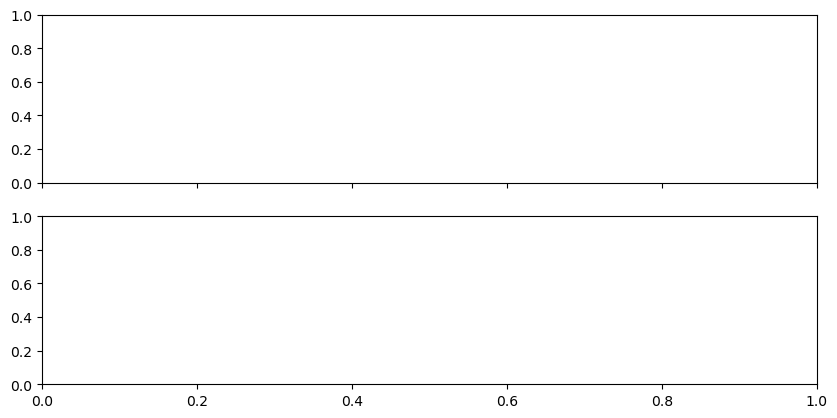

In [60]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(10,4.8))#len(res.r.unique()),len(res.n.unique())
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    print(whichrow,whichcol)
    #whichax = row['L'] - 2
#     color = colors[(row['L'])]
    print(rf"{row['r']},{row['n']},{row['L']}",row["Gradient Singular Values"]/np.sqrt(2048),whichrow,whichcol)
    ax[whichrow,whichcol].semilogy(row["Gradient Singular Values"]/np.sqrt(2048),label=rf"$L={row['L']}$",linewidth=1,alpha=0.7,marker=".")
    ax[whichrow,whichcol].set_xticks(list(range(3,20,4)),list(range(4,21,4)))
    ax[whichrow,whichcol].set_ylim(10**-9,10**3)
    ax[0,whichcol].set_title(rf"$n={row['n']}$")
    ax[-1,whichcol].set_xlabel(rf"Index, $k$")
plt.subplot(2,len(res.n.unique()),1)
leg = plt.legend()
leg = plt.legend(bbox_to_anchor=(-1, 1))
leg.get_frame().set_edgecolor('b')
leg.get_frame().set_linewidth(0.0)
plt.subplot(2,len(res.n.unique()),1)
plt.ylabel(r"$r=1$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
plt.yticks([10**p for p in range(-8,3,2)])
plt.subplot(2,len(res.n.unique()),len(res.n.unique())+1)
plt.ylabel(r"$r=2$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
plt.yticks([10**p for p in range(-8,3,2)])
plt.suptitle("Singular Values of Trained Networks")
plt.tight_layout()
plt.savefig(job_name+"/sv.png",dpi=300,bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

#  determine the L parameter that gets the best test MSE for each (r,n)

In [ ]:
testmse_vs_L = res.pivot_table(values="Test MSE",index = ("r","n","Activations"),columns=["L"])
testmse_vs_L = testmse_vs_L.iloc[:,1:]
testmse_vs_L

In [ ]:
bestL = testmse_vs_L.idxmin(axis=1)
bestL

In [ ]:
mask = [row["L"] == bestL[row["r"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]
bestLres

# Plots of L vs Test error and n vs Generalization metrics with/without linear layers

In [ ]:
res.r.unique()

In [ ]:
f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=True, figsize=(10,4.8))
for rnum,r in enumerate(res.r.unique()):
    for n in res.n.unique():
        res_rn = res[(res.r == r) * (res.n == n)]
        ax[rnum].scatter(res_rn.L,res_rn[["Test MSE"]])
        ax[rnum].semilogy(res_rn.L,res_rn[["Test MSE"]],label=rf"$n={n}$")
    ax[rnum].set_xlabel("$L$ number of layers")
    ax[rnum].set_title(rf"$r={r}$")
ax[0].legend()
ax[0].set_ylabel("Validation MSE")
f.suptitle(rf"Validation MSE for best $\lambda$ values")
f.tight_layout()
f.savefig(job_name+f"/Validation MSE.png",dpi=300)
plt.show()

In [ ]:
for metric in ['Generalization MSE', 'Out of Distribution MSE','Active Subspace Alignment Angle (Degrees)']:
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=True, figsize=(10,4.8))
    for rnum,r in enumerate(res.r.unique()):
        plt.subplot(1,2,r)
        #best L
        curr = bestLres[bestLres.r == r]
        ax[rnum].scatter(curr.n,curr[[metric]])
        ax[rnum].plot(curr.n,curr[[metric]],label=rf"linear layers")
        #no linear layers
        no_lin_layers = res[(res.r == r) * (res.L == 2)]
        ax[rnum].scatter(no_lin_layers.n,no_lin_layers[[metric]])
        ax[rnum].plot(no_lin_layers.n,no_lin_layers[[metric]],label=rf"no linear layers")
        #plotting extras
        ax[rnum].set_xlabel("$n$ number of samples")
        ax[rnum].set_xscale("log",base=2)
        if metric != 'Active Subspace Alignment Angle (Degrees)':
            ax[rnum].set_yscale("log",base=10)
        ax[rnum].set_title(rf"$r={r}$")
    ax[0].set_ylabel(f"{metric}")
    ax[0].legend()
    plt.suptitle(f"{metric}" + r" with best $(\lambda,L)$ tuning")
    plt.tight_layout()
    plt.savefig(job_name+f"/{metric}.png",dpi=300)
    plt.show()

# Final Table

In [ ]:
res.loc[(res.L == 2),"Activations"] = "Shallow ReLU"

In [ ]:
bestLres = pd.concat((res[(res.L == 2)],bestLres))

In [ ]:
bestLres.shape

In [ ]:
pivot_table = bestLres.pivot_table(index=("r","n","Activations"))
print(pivot_table.shape)
pivot_table

In [ ]:
pivot_table.idxmin(axis=0)

In [ ]:
pivot_table_latex = pivot_table.drop(["Final Weight Decay"],axis=1)
pivot_table_latex = pivot_table_latex[["L","lambda","Final Train MSE","Generalization MSE","Out of Distribution MSE","Active Subspace Alignment Angle (Degrees)"]]
pivot_table_latex.to_latex(float_format="%.2e")

In [ ]:
pivot_table_latex

# Training Time Plots

## Train MSE v Epoch

In [ ]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if row["L"] <= 4:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse234.png",dpi=300)
plt.show()

In [ ]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if 4 < row["L"] <= 7:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse567.png",dpi=300)
plt.show()

In [ ]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if row["L"] > 7:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse8910.png",dpi=300)
plt.show()

## Weight Decay v Epoch

In [ ]:
f, ax = plt.subplots(len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    ax[whichrow,whichcol].semilogy(row["Weight Decay"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
    ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Weight Decay v Epoch")
f.savefig(job_name+"/weightdecay.png",dpi=300)
plt.show()

## learning rates

In [ ]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    ax[whichrow,whichcol].semilogy(row["Learning Rate"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
    ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Learning Rate v Epoch")
f.savefig(job_name+"/LearningRate.png",dpi=300)
plt.show()